# MIRI imager simulator
This notebook is adapted from mirisim example notebooks: https://wiki.miricle.org/Public/MIRISimPublicRelease2dot4#User_Guide

In [98]:
# import the configuration file parsers so they can be written to file
from mirisim.config_parser import SimConfig, SimulatorConfig, SceneConfig

# import scene component generators
from mirisim.skysim import Background, sed, Point, Galaxy, kinetics
from mirisim.skysim import wrap_pysynphot as wS
from mirisim.skysim import externalsources

from mirisim import MiriSimulation


#other things to be used
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents
from astropy.io import fits # for reading FITS file contents

import matplotlib.pyplot as plt    # to display images
from matplotlib import colors,cm
%matplotlib inline        

## Create a Scene

The scene created below consists of a circle of point sources surrounding a Galaxy,and a low level background, all of which fit within the main imager field of view. The point sources all have the same (blackbody) SEDs to make things simple. The galaxy as a pysynphot SED which is modified by a Keplerian velocity field.

to be able to simply add the point sources ('stars') to a scene, it first needs to be initialised with a background

#### Create the background emission

In [99]:
bg = Background(level = 'low', gradient = 5., pa = 45.)

skycube = externalsources.Skycube("testfile_25lams.fits")

2021-05-12 14:41:25,418 - INFO - Initializing Background
2021-05-12 14:41:25,427 - INFO - Initializing Skycube
2021-05-12 14:41:25,429 - INFO - Loading external scene from FITS testfile_25lams.fits
  'DEG' -> 'deg',
  'DEG' -> 'deg'. [astropy.wcs.wcs]
  'DEG' -> 'deg',
  'DEG' -> 'deg'.
2021-05-12 14:41:27,974 - stpipe - WARNING - FITSFixedWarning: 'unitfix' made the change 'Changed units:
  'DEG' -> 'deg',
  'DEG' -> 'deg'.
  'DEG' -> 'deg',
  'DEG' -> 'deg'.
2021-05-12 14:41:28,153 - INFO - Aligning the centre of the fits file with the centre of the scene


## Initialise the Simulation Parameters

This is where the parameters for the MRS simulation get set. Note that for internal consistency in MIRISim, all settings (including those not used in the MRS simulation here) must be set. Those not being used in this simulation are labelled with <code> NOT USED HERE </code> in the comments of each line

In [100]:
sim_config = SimConfig.makeSim(
    name = 'sim_model1',    # name given to simulation
    scene = 'scene_model1.ini', # name of scene file to input
    rel_obsdate = 0.0,          # relative observation date (0 = launch, 1 = end of 5 yrs)
    POP = 'IMA',                # Component on which to center (Imager or MRS)
    ConfigPath = 'IMA_BRIGHTSKY',  # Configure the Optical path (MRS sub-band)
    Dither = False,             # Don't Dither
    StartInd = 1,               # start index for dither pattern [NOT USED HERE]
    NDither = 2,                # number of dither positions [NOT USED HERE]
    DitherPat = 'ima_recommended_dither.dat', # dither pattern to use [NOT USED HERE]
    disperser = 'SHORT',        # [NOT USED HERE]
    detector = 'SW',            # [NOT USED HERE]
    mrs_mode = 'SLOW',          # [NOT USED HERE]
    mrs_exposures = 2,          # [NOT USED HERE]
    mrs_integrations = 3,       # [NOT USED HERE]
    mrs_frames = 5,             # [NOT USED HERE]
    ima_exposures = 1,          # number of exposures
    ima_integrations = 2,       # number of integrations
    ima_frames = 1,             # number of groups (for MIRI, # Groups = # Frames)
    ima_mode = 'FAST',          # Imager read mode (default is FAST ~ 2.3 s)
    filter = 'F1000W',          # Imager Filter to use
    readDetect = 'BRIGHTSKY'         # Portion of detector to read out
)

### Export the simulation setup to a file

In [101]:
os.system('rm IMA_simulation.ini')
sim_config.write('IMA_simulation.ini')

## Run the simulation

Now that the scene and the setup of the simulation have been set, we can run the simulation.

the last step is to setup the defaults for internal things like CDPs.

In [102]:
simulator_config = SimulatorConfig.from_default()
scene_config = SceneConfig.makeScene(targets=[skycube], background=bg, name="sky0", loglevel=1)

mysim = MiriSimulation(sim_config, scene_config, simulator_config)
mysim.run()

2021-05-12 14:41:28,218 - INFO - MIRISim version: 2.4.0
2021-05-12 14:41:28,220 - INFO - MIRI Simulation started.
2021-05-12 14:41:28,223 - INFO - Output will be saved to: 20210512_144128_mirisim
2021-05-12 14:41:28,224 - INFO - Storing configs in output directory.
2021-05-12 14:41:28,229 - INFO - Storing dither pattern in output directory.
2021-05-12 14:41:28,232 - WARNING - Environment variable CDP_DIR is not set. Will look up / store CDP files at ./CDP
2021-05-12 14:41:28,234 - INFO - 
	*** Detector hard reset. NOTE: All latency and drift data will be erased.
2021-05-12 14:41:28,371 - INFO - Setting up simulated Observation, with following settings:
2021-05-12 14:41:28,372 - INFO - Configuration Path: IMA_BRIGHTSKY
2021-05-12 14:41:28,373 - INFO - Primary optical path: IMA
2021-05-12 14:41:28,375 - INFO - IMA Filter: F1000W
2021-05-12 14:41:28,376 - INFO - IMA Subarray: BRIGHTSKY
2021-05-12 14:41:28,377 - INFO - IMA detector readout mode: FAST
2021-05-12 14:41:28,378 - INFO - IMA de

## Examine some of the results

Now that the MIRISim simulation has completed, lets examine the results. 


The first thing to note is that the outputs are placed in a date-labelled directory taking the form  <code> YYYYMMDD_hhmmss_mirisim</code>.  The name of the output directory is given in the last line of the MIRISim log above.  Because the output directory is date-labelled, we can quantify which was the most recent run of MIRISim, and find its output directory using <code>glob.glob</code>

In [103]:
outputdir = sorted(glob.glob('*_*_mirisim'),key=os.path.getmtime)[-1]    #[-1] takes the last entry found

outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The subdirectories in the outputdirectory are:\n{}'.format(directories))
print('The files in the outputdirectory are:\n{}'.format(files))

The subdirectories in the outputdirectory are:
['det_images', 'illum_models']
The files in the outputdirectory are:
['simulator.ini', 'ima_recommended_dither.dat', 'scene.ini', 'simulation.ini', 'mirisim.log']


## Viewing the final detector image

The detector images are the final output of MIRISim, and have data structures and formatting consistent with what will come from MIRI itself. The data format is JWST pipeline ready.  Below an example image of the last frame of the last integration is shown. The units are <code>DN</code>.

Additionally, below the FITS header information for the SCIENCE extension is listed

In [104]:
def show_outputs(MIRISim_outputdir,output_type):
    '''
    plot the specified channel of the MIRISim outputs
    :param MIRISim_outputdir:  
        name of the date-labelled dir. holding the MIRISIM outputs
    :param output_type: 
        type of output to process 
        (e.g. illum_models, det_images or skycubes)
    '''
    
    infits = glob.glob('{}/{}/*.fits'.format(MIRISim_outputdir,output_type))[0]
    
    hdulist = fits.open(infits)

    hdu_index = 1
    if len(hdulist[hdu_index].data.shape) > 3:
        integ,frames,nx,ny = hdulist[hdu_index].data.shape
        image = hdulist[hdu_index].data[0,frames-1,:,:]      
    else:
        image = hdulist[hdu_index].data[0,:,:]
    min = image.mean() + 0.5 * image.std()
    max = image.max()
    norm = colors.LogNorm(min, max, clip=True) 
    #norm = colors.LogNorm(image.min(), image.max(), clip=True) 
    plt.imshow(image,origin = 'lower', cmap = cm.viridis,interpolation = 'nearest',norm = norm)
    plt.title('{}'.format(infits.split('/')[-1]))
    plt.xlabel("'RA' Direction")
    plt.ylabel("'DEC' Direction")
    plt.colorbar()
    print(min, max)

10986.725059509277 12849.0


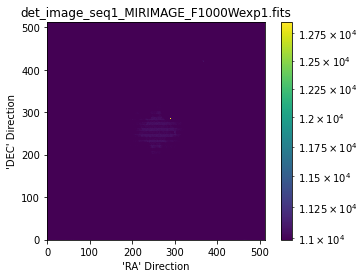

In [105]:
show_outputs(outputdir,'det_images')

infits = glob.glob('{}/det_images/*.fits'.format(outputdir))[0]
hdulist = fits.open(infits)
#hdulist[1].header